# 人工知能とソフトコンピューティング 第5回 多層パーセプトロン 演習


## 分析対象となるデータの準備

### ステップ0
データを読み込むためのパスの基準を指定します。

In [1]:
base_path = '.'

### ステップ1
必要なライブラリをインポートする  

In [2]:
from pathlib import Path # ファイルパスの取り扱い
import matplotlib.pyplot as plt # グラフ描画
import matplotlib.cm # 描画色の管理・生成
from matplotlib.colors import ListedColormap # カラーマップ
import numpy as np # 数値取扱い
import pandas as pd # ファイル読み込み，データフレーム
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split # 訓練データとテストデータの分割
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as L
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics import Accuracy

### ステップ2
CSVファイルからデータを読み込む  
* data1.csv: ランダムに二つの固まりを生成した200個の点（第4回と同じもの：線形分離できそう）
* data2.csv: ランダムに二つの固まりを生成した 10,000個の点（線形分類できそうにない）
* data3.csv: ランダムに三つの固まりを生成した300個の点（第4回の data3.csvと同じもの：線形分離できそうにない）
* data4.csv: 課題用：ランダムに10個の固まりを生成した 10,000個の点（線形分類できそうにない）

In [3]:
dataframe = pd.read_csv(Path(base_path, "05_data", "data1.csv"))
dataframe_X = dataframe[["x", "y"]]
X = np.array(dataframe_X.values.reshape(-1, 2)) # numpy の二次元データの array に変換
t = dataframe.t.values.reshape(-1) # numpy の一次元データのarrayに変換

### ステップ3
読み込んだデータを平均と標準偏差を用いて正規化  
scikit-learn の StandardScaler を利用

In [4]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

### ステップ4
読み込んだデータを散布図にして確認する

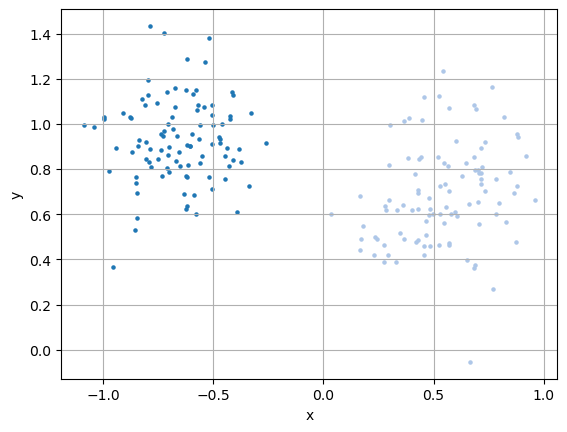

In [5]:
n_classes = len(np.unique(t)) # 分類クラス数
def show_scatter(subplot, X, t, emph = False): # X: 散布表示する点（x,y) の配列，t: (x,y)がどの分類かのラベル，cmap: 色リスト，emph: 強調するか否か
    subplot.set_xlabel("x")
    subplot.set_ylabel("y")
    classes = np.unique(t) # 分類結果のラベルに出現するクラス（配列）
    for i in classes: # 正解ラベルの種類数だけ繰り返す（正解データから種類数を読み取る）
        if emph == True: # 点を強調して表示（サイズを大きくして，縁取りを付ける）
            subplot.scatter(X[t == i, 0], X[t == i, 1], marker = "o", color = plt.cm.tab20(i), linewidth = 0.5, edgecolor = "black", s = 15)
        else: # 通常表示
            subplot.scatter(X[t == i, 0], X[t == i, 1], marker = "o", color = plt.cm.tab20(i), s = 5)

fig = plt.figure()
subplot = fig.add_subplot()
show_scatter(subplot, scaler.inverse_transform(X), t) # 標準化の逆変換で元の（ファイルから読み込んだ）値に戻して表示
subplot.grid()
plt.show()

### ステップ5
訓練データ，評価データ，テストデータに分離  
scikit-learn の train_test_split() を用いる
* X_train: 訓練用の (x, y) の array
* t_train: 訓練用の t (正解ラベル) の array
* X_val: 検証用の (x, y) の array
* t_val: 検証用の r (正解ラベル) の array
* X_test: テスト用の (x, y) の array
* t_test: テスト用の r (正解ラベル) の array

PytorchではTensor型のデータを用いる
訓練・検証・テストの入力に使いやすいTensorDataset型に変換

In [6]:
train_ratio = 0.8 # 訓練データの割合
validation_ratio = 0.1 # 検証データの割合
test_ratio = 0.1 # テストデータの割合

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=1 - train_ratio, random_state=0)
X_val, X_test, t_val, t_test = train_test_split(X_test, t_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=0) 

# データをTensorに変換
X_train_t = torch.from_numpy(X_train).float()
t_train_t = torch.from_numpy(t_train).long()
X_val_t = torch.from_numpy(X_val).float()
t_val_t = torch.from_numpy(t_val).long()
X_test_t = torch.from_numpy(X_test).float()
t_test_t = torch.from_numpy(t_test).long()

# Pytorchで使いやすいTensorDatasetに変換
train_dataset = TensorDataset(X_train_t, t_train_t)
val_dataset = TensorDataset(X_val_t, t_val_t)
test_dataset = TensorDataset(X_test_t, t_test_t)

## 単純（単層）パーセプトロンの構造定義と訓練方法の設定

### ステップ6
次の構造を持つニューラルネットワークのアーキテクチャを定義
* Linear: 全結合層（これが単純パーセプトロンにあたる）

次の訓練方法を設定
* 重み計算の最適化アルゴリズム SGD（確率的勾配降下法）
* 損失関数（モデルと期待との差異を評価する尺度）CrossEntropyEntropyLoss（クロスエントロピー損失）
* 訓練中に訓練データと評価データに対して取得する値 accuracy （分類精度）

In [7]:
class SingleLayerPerceptron(L.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.save_hyperparameters() # ハイパーパラメータを保存
        self.example_input_array = torch.zeros((1, input_size)) # モデルサマリ用のダミー入力

        # 単純パーセプトロンのモデル定義
        # 入力層: input_size に対応
        # 出力層: num_classes に対応
        self.model = nn.Linear(in_features=input_size, out_features=num_classes)

        # 損失関数: クロスエントロピー損失関数（多クラス分類用）
        self.criterion = nn.CrossEntropyLoss()
        
        # 評価指標: 訓練・検証・テストでの精度計算用
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        # 順伝播でモデルの出力を計算
        return self.model(x)

    def configure_optimizers(self):
        # オプティマイザ: SGD（確率的勾配降下法）
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01) # デフォルトの学習率を設定
        return optimizer

    def training_step(self, batch, batch_idx):
        # 訓練データのバッチを使って損失を計算
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        # 損失と精度を記録
        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        
        # on_epoch=True でエポック終了時に損失と精度の平均値を記録
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 検証データのバッチを使って損失を計算(training_stepと同様だが戻り値は不要)
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', self.val_acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # テストデータのバッチを使って損失を計算(training_stepと同様だが戻り値は不要)
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', self.test_acc, on_step=False, on_epoch=True)

### ステップ7
定義した設定の概要を確認  
モデル定義の行（model）を見て、入出力関係（大きさ，次元数）に設計との不一致や層間の不整合がないかを確認する
* Type: レイヤの種類
* Params: 学習により決定するパラメータ（重み）の数
* In sizes: 入力データの形式
* Out sizes: 出力データの形式

In [8]:
ModelSummary(SingleLayerPerceptron(input_size=2, num_classes=n_classes), max_depth=-1)

  | Name      | Type               | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------------
0 | model     | Linear             | 6      | train | [1, 2]   | [1, 2]   
1 | criterion | CrossEntropyLoss   | 0      | train | ?        | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?        | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?        | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?        | ?        
--------------------------------------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode

## 単純パーセプトロンの訓練

### ステップ8

単純パーセプトロンのモデルをインスタンス化して
訓練時にデータをモデルに読み込むためのDataLoaderを作成する

モデルに訓練データを投入し，ネットワークの「重み」を計算
* 訓練データ（座標と正解ラベル）
* エポック数：10（変更可）
* バッチサイズ：1（変更可）
* 訓練結果の評価データ（座標と正解ラベル）
* 訓練の履歴を記録

バッチサイズで訓練データを分割し，すべての訓練データに対して繰り返しパラメータを最適化するまでの処理が1エポック  
訓練データの数 / バッチサイズ で 1エポックでの繰り返し数が決まる  
* バッチサイズが1の時，1回の繰り返しで1個の訓練データに対する損失の勾配を計算し，勾配を下る方向に重みを更新（確率的勾配降下法）．1エポックでの重み更新は訓練データ数回繰り返す．  
* バッチサイズが訓練データ数の時，1回の繰り返しで全訓練データに対する損失の勾配を計算し，勾配を下る方向に重みを更新（最急降下法）．1エポックでの重み更新は1回．  
* バッチサイズが1から訓練データ数の間の時，1回の繰り返しでバッチサイズ個の訓練データに対する損失の勾配を計算し，勾配を下る方向に重みを更新（ミニバッチSGD）．1エポックでの重み更新は 訓練データ数 / バッチサイズ

バッチサイズを大きくすると1エポックの計算時間は短くなる．

In [9]:
epochs = 10 # エポック数
# バッチサイズ
batch_size = 1 # 確率的勾配降下法 
# batch_size = 8 # ミニバッチSDG（バッチサイズ変更可）
# batch_size = len(X_train) # 最急降下法

# 1. データローダーとモデルのインスタンス化

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False # 検証データはシャッフルしない
)

single = SingleLayerPerceptron(
    input_size=2,
    num_classes=n_classes
)

# 2. 訓練履歴を記録するロガーと訓練方法の設定

# 訓練中にモデルを保存するコールバック関数
checkpoint_callback_slp = L.callbacks.ModelCheckpoint(
    #dirpath=Path(base_path, "models", "slp"), # モデル保存先フォルダ
    save_last=True, # 最後のエポックのモデルを last.ckpt として保存
)

# CSVLoggerは、訓練履歴をmetrics.csvに自動保存します
log_folder = Path(base_path, "logs")
slp_logger = L.loggers.CSVLogger(log_folder, name='slp')
slp_trainer = L.Trainer(
    max_epochs=epochs,
    logger=slp_logger,
    callbacks=[checkpoint_callback_slp],
    deterministic=True, # 再現性のために決定論的動作を有効化
    # プログレスバーに表示されるメトリクスを制御
    enable_progress_bar=True
)

# 3. 訓練開始
slp_trainer.fit(single, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------------
0 | model     | Linear             | 6      | train | [1, 2]   | [1, 2]   
1 | criterion | CrossEntropyLoss   | 0      | train | ?        | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?        | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?        | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?        | ?        
--------------------------------------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 160/160 [00:03<00:00, 45.39it/s, v_num=1, val_loss=0.0382, train_loss=0.0528]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:03<00:00, 45.03it/s, v_num=1, val_loss=0.0382, train_loss=0.0528]


### ステップ9
訓練履歴（精度，損失）の確認
* 訓練用データに対する分類の精度と評価用データに対する分類の精度
* 訓練用データに対する損失と評価用データに対する損失

これらのエポック毎の記録が訓練履歴フォルダに保存されているので，読み込んでグラフに描画することで，学習が進むにつれてどのように変化したかを把握することができる 

In [10]:
# 訓練履歴の読み込み関数
def load_history(log_path):
    log_file = Path(log_path, "metrics.csv")
    history = pd.read_csv(log_file)
    # 記録のタイミングにより欠損値があるため，欠損値のある行を削除
    train_history = history.dropna(subset=['train_accuracy']).reset_index(drop=True) 
    val_history = history.dropna(subset=['val_accuracy']).reset_index(drop=True)
    return train_history, val_history

記録から学習が進むにつれてどのように変化したかをグラフに描画して把握するための関数を定義

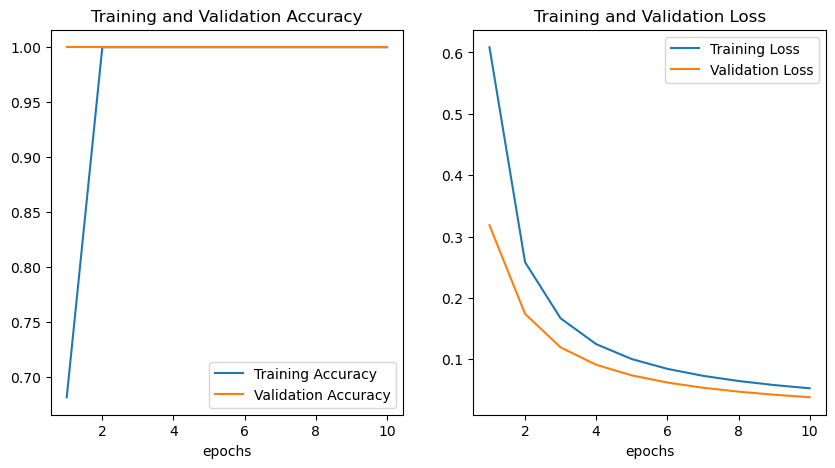

In [11]:
def show_accuracy_and_loss_graphs(train_history, val_history, epochs, epoch_from = 1): # 訓練履歴（精度・損失）を描画する関数
    training_accuracies = train_history["train_accuracy"] # 訓練用データに対する精度
    validation_accuracies = val_history["val_accuracy"] # 評価用データに対する精度
    training_losses = train_history["train_loss"] # 訓練用データに対する損失
    validation_losses = val_history["val_loss"] # 評価用データに対する損失
    
    epochs_range = range(epoch_from, epochs + 1) # 1 から epochs までの描画範囲を指定
    figure = plt.figure(figsize = (10, 5))
    subplot = plt.subplot(1, 2, 1)
    subplot.plot(epochs_range, training_accuracies, label = "Training Accuracy") # 訓練用データに対する精度のグラフ描画
    subplot.plot(epochs_range, validation_accuracies, label = "Validation Accuracy") # 評価用データに対する精度のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    plt.title("Training and Validation Accuracy")
    subplot = plt.subplot(1, 2, 2)
    subplot.plot(epochs_range, training_losses, label = "Training Loss") # 訓練用データに対する損失のグラフ描画
    subplot.plot(epochs_range, validation_losses, label = "Validation Loss") # 評価用データに対する損失のグラフ描画
    subplot.set_xlabel("epochs")
    subplot.legend()
    plt.title("Training and Validation Loss")
    plt.show()

#　Notebookと同じフォルダに保存された訓練履歴を読み込む。実行ごとにversion番号が変わるのでf文字列を使用
log_path = Path(log_folder, "slp", f"version_{slp_trainer.logger.version}")
slp_train_history, slp_val_history = load_history(log_path)

# 定義した関数を呼び出してグラフを表示
show_accuracy_and_loss_graphs(slp_train_history, slp_val_history, epochs)

## 訓練済みの単純パーセプトロンによる分類タスクの実行

### ステップ10
訓練したモデルにテスト用データを与えて評価する
* テスト用データ
* 返値は評価結果（損失と予測精度の値）

In [12]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=len(test_dataset), # テストデータ全体を1つのバッチとして処理
    shuffle=False
)
print(slp_trainer.test(dataloaders=test_dataloader))

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │    0.07663698494434357    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07663698494434357, 'test_accuracy': 1.0}]


### ステップ11
平面上の点を与えて，それぞれ予測結果を出し，領域を色付けする．（第4回と同様の処理）  
関数 show_classification_regions() を定義して呼び出し  
表示するデータは正規化後のもの，ステップ4で表示したグラフとはスケールが異なる（分布の状況は同じ）

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.00it/s]

Restoring states from the checkpoint path at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


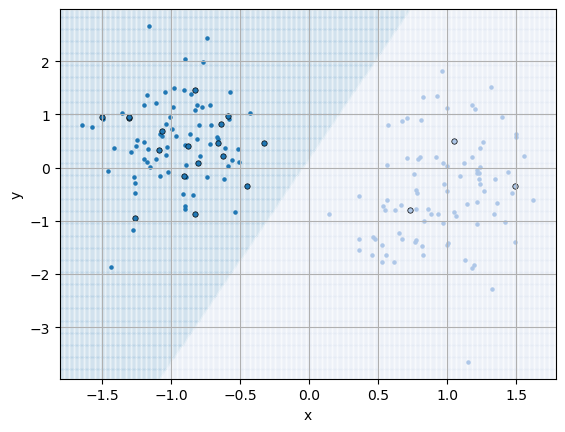

In [13]:
# グラフをプロットする範囲を計算(関数定義）
def calculate_plot_range(X):
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()
    return xmin, xmax, ymin, ymax

# 予測した結果を領域表示する関数
def show_classification_regions(trainer, subplot, X):
    # グラフをプロットする範囲を計算
    xmin, xmax, ymin, ymax = calculate_plot_range(X)
    # グラフの表示範囲を設定
    xmin, xmax, ymin, ymax = xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin), ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax -ymin)
    subplot.set_xlim(xmin, xmax)
    subplot.set_ylim(ymin, ymax)
    # 予測に与えるサンプルを取るメッシュの解像度（0.0025 * (max - min)
    xres = 0.0025 * (xmax - xmin)
    yres = 0.0025 * (ymax - ymin)
    xmesh, ymesh = np.meshgrid(np.arange(xmin, xmax, xres), np.arange(ymin, ymax, yres)) # 等間隔で (x, y) のメッシュを作成
    mesh = np.array([xmesh.ravel(), ymesh.ravel()]).T

    # メッシュデータをTensorに変換して予測
    mesh_t = torch.from_numpy(mesh).float()
    probs = trainer.predict(dataloaders=DataLoader(mesh_t, batch_size=len(mesh_t), shuffle=False))
    probs = torch.cat(probs, dim=0) # バッチごとの予測結果を結合
    pred = torch.argmax(probs, dim=1).numpy() # 各メッシュ点の予測クラスを取得してnumpy配列に変換

    for i in range(n_classes):
        Ith = mesh[pred == i]
        subplot.scatter(Ith[:, 0], Ith[:, 1], color = plt.cm.tab20(i), alpha = 0.3, s = 0.05, marker = ".")

# 予測結果の領域表示
show_classification_regions(slp_trainer, subplot, X)
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
show_classification_regions(slp_trainer, subplot, X)
show_scatter(subplot, X_train, t_train)
show_scatter(subplot, X_test, t_test, True)
subplot.grid()
plt.show()

## 多層パーセプトロンの構造定義と訓練方法の設定

### ステップ12
次の構造を持つニューラルネットワークのアーキテクチャ（Sequential：逐次構造）を定義
* Layer: 全結合層（多層パーセプトロンのX段目：隠れ層）の繰り返し
* Layer: 全結合増（多層パーセプトロンの最終段目：出力層）n_class次元のベクトルを出力（活性化関数はソフトマックス関数）
* 層の構成，次元数，活性化関数を変更して結果がどうかるかを確認してみると良い

次の訓練方法を設定
* 重み計算の最適化アルゴリズム SGD（確率的勾配降下法）
* 損失関数（モデルと期待との差異を評価する尺度）CrossentropyEntropyLoss（クロスエントロピー損失）
* 訓練中に訓練データと評価データに対して取得する値 accuracy （分類精度）

In [14]:
# 単層パーセプトロンとの違いは、self.model の定義部分だけです。
class MultiLayerPerceptron(L.LightningModule):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.save_hyperparameters() # ハイパーパラメータを保存
        self.example_input_array = torch.zeros((1, input_size)) # モデルサマリ用のダミー入力

        # 多層パーセプトロンのモデル定義
        # 入力層: input_size に対応
        # 出力層: num_classes に対応
        self.model = nn.Sequential( # 逐次的にデータを渡すパイプライン
            # Linear: 全結合層　入力されるデータに対するユニット，隠れ層（中間層），出力層の間を全て結合したネットワーク，
            #                  最終層の出力次元数は分類数，活性化関数はソフトマックス関数
            #                  各クラスに分類される確率が出力される
            #                  隠れ層の活性化関数は ReLU関数（tanh などを選んでも良い）
            #
            nn.Linear(in_features = 2, out_features = 4),
            nn.ReLU(),                  
            nn.Linear(in_features = 4, out_features = 8),
            nn.ReLU(),
            #nn.Linear(in_features = 8, out_features = 16),
            #nn.ReLU(),
            #nn.Linear(in_features = 16, out_features = 32),
            #nn.ReLU(),
            #nn.Linear(in_features = 32, out_features = 64),
            #nn.ReLU(),
            #nn.Linear(in_features = 64, out_features = 32),
            #nn.ReLU(),
            #nn.Linear(in_features = 32, out_features = 16),
            #nn.ReLU(),
            #nn.Linear(in_features = 16, out_features = 8),
            #nn.ReLU(),
            nn.Linear(in_features = 8, out_features = 4),
            nn.ReLU(),
            nn.Linear(in_features = 4, out_features = num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()
        
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01) # デフォルトの学習率を設定
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.train_acc(preds, y)
        
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.val_acc(preds, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', self.val_acc, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        self.test_acc(preds, y)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', self.test_acc, on_step=False, on_epoch=True)

ModelSummary(MultiLayerPerceptron(input_size=2, num_classes=n_classes), max_depth=-1)

   | Name      | Type               | Params | Mode  | In sizes | Out sizes
---------------------------------------------------------------------------------
0  | model     | Sequential         | 98     | train | [1, 2]   | [1, 2]   
1  | model.0   | Linear             | 12     | train | [1, 2]   | [1, 4]   
2  | model.1   | ReLU               | 0      | train | [1, 4]   | [1, 4]   
3  | model.2   | Linear             | 40     | train | [1, 4]   | [1, 8]   
4  | model.3   | ReLU               | 0      | train | [1, 8]   | [1, 8]   
5  | model.4   | Linear             | 36     | train | [1, 8]   | [1, 4]   
6  | model.5   | ReLU               | 0      | train | [1, 4]   | [1, 4]   
7  | model.6   | Linear             | 10     | train | [1, 4]   | [1, 2]   
8  | criterion | CrossEntropyLoss   | 0      | train | ?        | ?        
9  | train_acc | MulticlassAccuracy | 0      | train | ?        | ?        
10 | val_acc   | MulticlassAccuracy | 0      | train | ?        | ?        
11 | t

### ステップ13

定義したニューラルネットワークに訓練データを与えて訓練する
* エポック数は 10 (変更可)
* バッチサイズは 1 (変更可)
* 最適化アルゴリズムは SGD (モデル定義のconfigure_optimizersで変更可)

In [15]:
epochs = 10 # エポック数
# バッチサイズ
batch_size = 1 # 確率的勾配降下法 
# batch_size = 8 # ミニバッチSDG（バッチサイズ変更可）
# batch_size = len(X_train) # 最急降下法

# バッチサイズを変更したので、再度データローダーを作成
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

multi = MultiLayerPerceptron(
    input_size=2,
    num_classes=n_classes
)

# 単層パーセプトロンとモデルやログを保存するフォルダを分ける
checkpoint_callback_mlp = L.callbacks.ModelCheckpoint(
    save_last=True, # 最後のエポックのモデルを last.ckpt として保存
)

mlp_logger = L.loggers.CSVLogger(log_folder, name='mlp')
mlp_trainer = L.Trainer(
    max_epochs=epochs,
    logger=mlp_logger,
    callbacks=[checkpoint_callback_mlp],
    deterministic=True,
    enable_progress_bar=True
)

mlp_trainer.fit(multi, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------------
0 | model     | Sequential         | 98     | train | [1, 2]   | [1, 2]   
1 | criterion | CrossEntropyLoss   | 0      | train | ?        | ?        
2 | train_acc | MulticlassAccuracy | 0      | train | ?        | ?        
3 | val_acc   | MulticlassAccuracy | 0      | train | ?        | ?        
4 | test_acc  | MulticlassAccuracy | 0      | train | ?        | ?        
--------------------------------------------------------------------------------
98        Trainable params
0         Non-trainable params
98        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 160/160 [00:01<00:00, 99.90it/s, v_num=1, val_loss=0.0067, train_loss=0.0117] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:01<00:00, 98.95it/s, v_num=1, val_loss=0.0067, train_loss=0.0117]


### ステップ14

訓練履歴のグラフと訓練済みのモデルに対してテストデータを与えた時の精度，損失の値を表示

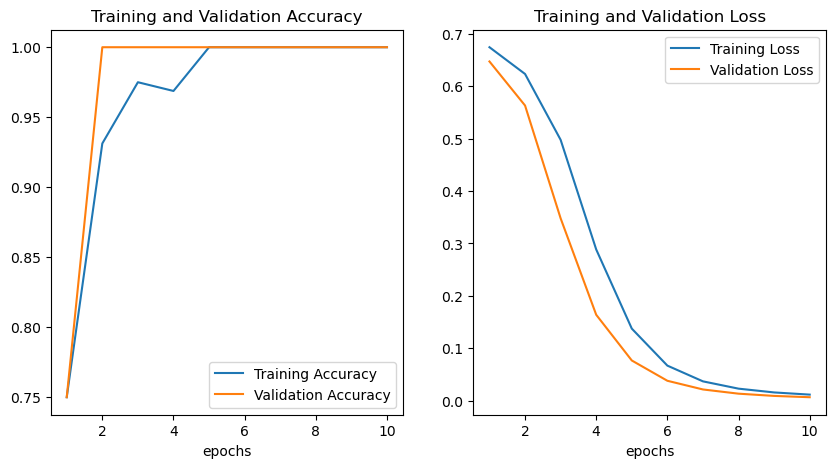

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\mlp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\mlp\version_1\checkpoints\epoch=9-step=1600.ckpt
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.71it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │            1.0            │
│         test_loss         │   0.010867757722735405    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.010867757722735405, 'test_accuracy': 1.0}]


In [16]:
log_path = Path(log_folder, "mlp", f"version_{mlp_trainer.logger.version}")
mlp_train_history, mlp_val_history = load_history(log_path)

show_accuracy_and_loss_graphs(mlp_train_history, mlp_val_history, epochs)
print(mlp_trainer.test(dataloaders=test_dataloader))

### ステップ15

訓練済みのモデルを用い，予測結果の領域を表示  
比較対象として単純パーセプトロンを用いた時の領域も表示

c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs\mlp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\mlp\version_1\checkpoints\epoch=9-step=1600.ckpt
c:\Users\Nanaki Ohashi\anaconda3\envs\AI-Soft-Prac\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


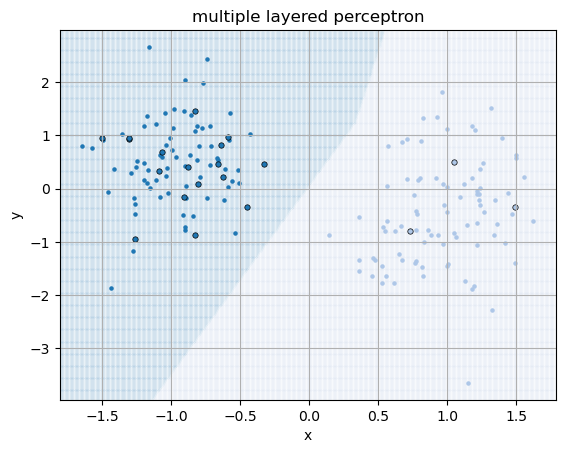

Restoring states from the checkpoint path at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt
Loaded model weights from the checkpoint at logs\slp\version_1\checkpoints\epoch=9-step=1600.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.16it/s] 


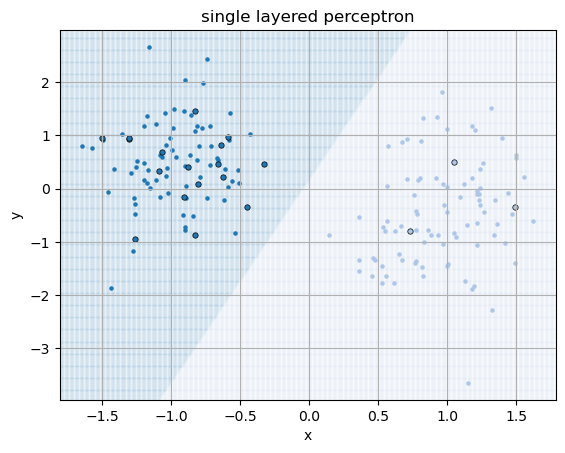

In [17]:
# 予測結果の領域表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
subplot.set_title("multiple layered perceptron")
show_classification_regions(mlp_trainer, subplot, X)
show_scatter(subplot, X_train, t_train)
show_scatter(subplot, X_test, t_test, True)
subplot.grid()
plt.show()

# 比較対象として，単純パーセプトロンによる予測結果を再表示
fig = plt.figure()
subplot = fig.add_subplot()
subplot.set_xlabel("x")
subplot.set_ylabel("y")
subplot.set_title("single layered perceptron")
show_classification_regions(slp_trainer, subplot, X)
show_scatter(subplot, X_train, t_train)
show_scatter(subplot, X_test, t_test, True)
subplot.grid()
plt.show()